In [1]:
import sys
import getopt
import math
import numpy as np
from netCDF4 import Dataset as NC
import matplotlib.pyplot as plt
import tqdm
from scipy import ndimage
from scipy import spatial
import copy
import subprocess
import rasterio
from rasterio.plot import show
import geopandas as gpd
from rasterio import mask
from inpaint_nans import inpaint_nans
from scipy.ndimage import zoom
from sklearn.metrics import mean_squared_error
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

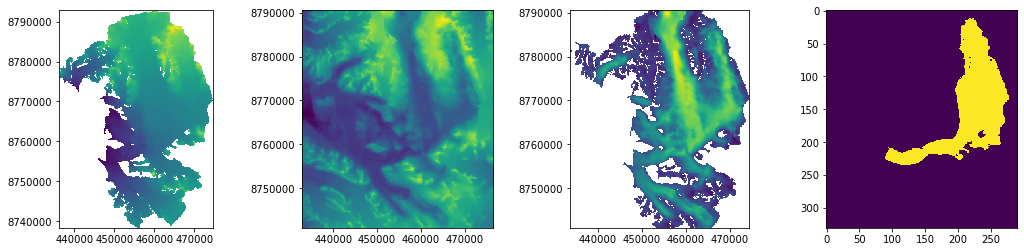

In [2]:
### data from lindbäck et al. (2018)
surf_o = rasterio.open("TIGRIF_DEM_ice_surface_150m_v1.tif") #from 2014
thk_o = rasterio.open("TIGRIF_DEM_ice_thickness_150m_1.tif") #from 2014, 2015, 2016 and some from 2000s
bed_o = rasterio.open("TIGRIF_DEM_subglacial_elevation_150m_v1.tif")

surf = surf_o.read(1)
thk = thk_o.read(1)
bed = bed_o.read(1)

### rgi outline
outline = gpd.read_file('./rgi_outlines/07_rgi60_Svalbard.shp')
outline_Kr = outline.to_crs(bed_o.crs)
outline_Kr = outline_Kr.loc[outline_Kr['RGIId'] == 'RGI60-07.01464', 'geometry']

bed_mask, bed_mask_meta = rasterio.mask.mask(bed_o, outline_Kr, crop=False)
surf_mask, surf_mask_meta = rasterio.mask.mask(surf_o, outline_Kr, crop=False)
thk_mask, thk_mask_meta = rasterio.mask.mask(thk_o, outline_Kr, crop=False)
mask_Kr = np.ones_like(bed_mask[0])
mask_Kr[bed_mask[0]>1e37]=0

fig, ax = plt.subplots(1,4, figsize=(18,4))
field1 = show(surf_o, ax = ax[0])
field2 = show(bed_o, ax = ax[1])
field3 = show(thk_o, ax = ax[2])
#outline.plot(ax=ax[2])
field4 = show(mask_Kr)

In [3]:
#### data from Jack ###
import scipy.io
mat_DEM_Vel = scipy.io.loadmat('HDF_2021_10_06.mat')
x_50m, y_50m = np.meshgrid(mat_DEM_Vel['HDF'][0,0][0], np.arange(np.min(mat_DEM_Vel['HDF'][0,0][1]), np.max(mat_DEM_Vel['HDF'][0,0][1])+10050, 50))

Z_50m_09 = np.zeros((int(((np.max(y_50m)+50)-np.min(y_50m))/50), int((np.max(x_50m)+50-np.min(x_50m))/50)))
Z_50m_09[:np.shape(Z_50m_09)[0]-int(10000/50),:] = mat_DEM_Vel['HDF'][0,0][3]
Z_50m_14 = np.zeros((int(((np.max(y_50m)+50)-np.min(y_50m))/50), int((np.max(x_50m)+50-np.min(x_50m))/50)))
Z_50m_14[:np.shape(Z_50m_14)[0]-int(10000/50),:] = mat_DEM_Vel['HDF'][0,0][4]

R2_50m_Vx = mat_DEM_Vel['HDF'][0,0][6]
R2_50m_Vx[np.isnan(R2_50m_Vx)] = 0
R2_50m_Vy = mat_DEM_Vel['HDF'][0,0][7]
R2_50m_Vy[np.isnan(R2_50m_Vy)] = 0
R2_50m_Vel = mat_DEM_Vel['HDF'][0,0][8]
R2_50m_Vel[np.isnan(R2_50m_Vel)] = 0

mat_RADAR = scipy.io.loadmat('HDF_radar_data.mat')
x_rad = mat_RADAR['HDF_radar_data'][0,0][0]
y_rad = mat_RADAR['HDF_radar_data'][0,0][1]
xy_rad = np.stack([x_rad, y_rad], axis=1)[:,:,0]
rad = mat_RADAR['HDF_radar_data'][0,0][2]

In [4]:
### official 50 m NPI DEM ###
NPI_DEM_o = rasterio.open("./S0_DTM50.tif")
window = (NPI_DEM_o.window(np.min(x_50m), np.min(y_50m), np.max(x_50m), np.max(y_50m),1))
NPI_50m_DEM = np.zeros_like(Z_50m_09)
NPI_50m_DEM[1:,1:] = np.flip(NPI_DEM_o.read(1, window = window), axis=0)  ## NPI_DEM is not correctly oriented when imported (no idea why), therefore it needs to be flipped

In [5]:
### get mask of Kongsbreen, reproject it and set it to the correct spot in the raster ###
outline_Ko = outline.to_crs(NPI_DEM_o.crs)
outline_Ko = outline_Ko.loc[outline_Ko['RGIId'] == 'RGI60-07.01482', 'geometry']
NPI_mask, NPI_mask_meta = rasterio.mask.mask(NPI_DEM_o, outline_Ko, crop=True)
NPI_mask = np.flip(NPI_mask[0], axis=0)
NPI_mask[NPI_mask<-1e37] = 0
NPI_mask[NPI_mask>0] = 1

#coordinates of upper left corner of cropped (using window) NPI DEM
x_ul_NPI_DEM = window.col_off*50+NPI_DEM_o.transform[2]  
y_ul_NPI_DEM = window.row_off*-50+NPI_DEM_o.transform[5]

## amount of pixels that NPI_mask needs to be shifted to be at right spot in the raster
shift_x = int((NPI_mask_meta[2] - x_ul_NPI_DEM)/50)
shift_y = int((NPI_mask_meta[5] - y_ul_NPI_DEM)/50)

mask_50m_Ko = np.zeros_like(NPI_50m_DEM)
mask_50m_Ko[(np.shape(mask_50m_Ko)[0]-np.shape(NPI_mask)[0]+shift_y):(np.shape(mask_50m_Ko)[0]+shift_y), shift_x:(shift_x+np.shape(NPI_mask)[1])]=NPI_mask

In [6]:
### masks ###
#mask_50m = -1*np.logical_or(np.isnan(Z_50m_14), np.isnan(Z_50m_09))+1
mask_50m = -1*np.isnan(Z_50m_14)+1
retreat_50m_mask = np.zeros_like(mask_50m)
retreat_50m_mask[np.logical_and(NPI_50m_DEM<100, np.logical_and(Z_50m_09>1, -1*mask_50m+1))] = 1
retreat_50m_mask[retreat_50m_mask+mask_50m==2]=0

#retreat_50m_mask = np.logical_and(np.logical_and(-1*np.isnan(Z_50m_09)+1, mask_50m == 0), NPI_50m_DEM < 100)

#mask_50m *= (-1*retreat_50m_mask+1)

mask_50m[np.shape(mask_50m)[0]-int(10000/50):,:]=0

mask_50m_full = mask_50m_Ko + mask_50m
mask_50m_full[mask_50m_full>0] = 1

In [7]:
### set bed elevation under water to -700 m ###
#ocean_50m = (np.logical_and(NPI_50m_DEM<=10, mask_50m==0))
NPI_50m_DEM[retreat_50m_mask==1] = -700

### fill nan values ###
Z_50m_09[mask_50m_full==0]=NPI_50m_DEM[mask_50m_full==0]
Z_50m_09[np.isnan(Z_50m_09)] = NPI_50m_DEM[np.isnan(Z_50m_09)]

Z_50m_14[mask_50m_full==0]=NPI_50m_DEM[mask_50m_full==0]
Z_50m_14[np.isnan(Z_50m_14)] = NPI_50m_DEM[np.isnan(Z_50m_14)]

### calculate dhdt ###
dhdt_50m_0914 = (Z_50m_14 - Z_50m_09)/5
dhdt_50m_0914[np.isnan(dhdt_50m_0914)] = 0

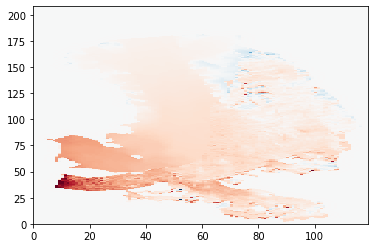

In [8]:
## fit dhdt for Kongsbreen ##
poly = np.poly1d(np.polyfit(NPI_50m_DEM[mask_50m == 1],dhdt_50m_0914[mask_50m == 1],1))
dhdt_50m_fit = poly(NPI_50m_DEM)
dhdt_50m_fit[mask_50m == 1]=0
dhdt_50m_fit[mask_50m_Ko == 0]=0

## full dhdt
dhdt_50m_full = dhdt_50m_fit+dhdt_50m_0914

plt.pcolor(zoom(dhdt_50m_full, 50/250), cmap='RdBu', vmin=-5, vmax=5)

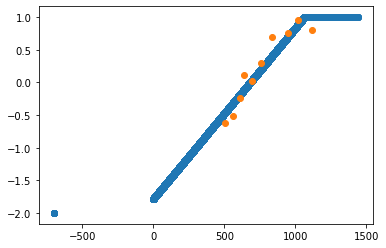

In [9]:
### mass balance from Jack in cm.w.eq. ###
import pandas as pd

smb_xyz_df = pd.read_excel ('HDF_mass_balance.xlsx', 0, header=None)
smb_net_df = pd.read_excel ('HDF_mass_balance.xlsx', 3, header=None)

smb_x = np.array(smb_xyz_df.loc[:,1])
smb_y = np.array(smb_xyz_df.loc[:,2])
smb_z = np.array(smb_xyz_df.loc[:,3])

smb_net_0914 = np.array(smb_net_df.loc[1:,7:12])/100*(10/9)   #convert to m.ice.eq.
smb_net_0914 = np.nanmean(smb_net_0914, axis=1)

### interpolate smb with elevation ###
from scipy import optimize

#def piecewise_linear(x):
#    return np.piecewise(x, [x < 0, x>=0], [lambda x: -x, lambda x: x])

#p , e = optimize.curve_fit(piecewise_linear, smb_z, smb_net_1421)
#test = piecewise_linear(Z_14, *p)

poly = np.poly1d(np.polyfit(smb_z,smb_net_0914,1))
smb_50m_fit = poly(NPI_50m_DEM)
smb_50m_fit[smb_50m_fit<-2] = -2
smb_50m_fit[smb_50m_fit>1] = 1


plt.scatter(NPI_50m_DEM, smb_50m_fit)
plt.scatter(smb_z, smb_net_0914)

In [10]:
### velocity from Jack ###
vel_xyz_df = pd.read_excel('HDF_stake_velocities.xlsx', 1, header=None)
vel_x = np.array(vel_xyz_df.loc[:,1])
vel_y = np.array(vel_xyz_df.loc[:,2])
vel_z = np.array(vel_xyz_df.loc[:,3])

vel_df = pd.read_excel ('HDF_stake_velocities.xlsx', 0, header=None)
vel_0914 = np.nanmean(np.array(vel_df.loc[3:,range(10,18,2)]), axis=1)


In [11]:
### adjust resolution ###

data_res = 50
res = 250
resample = data_res/res

Z_09 = zoom(Z_50m_09, resample)
Z_14 = zoom(Z_50m_14, resample)
dhdt_full = zoom(dhdt_50m_full, resample)
smb_fit = zoom(smb_50m_fit, resample)
NPI_DEM = zoom(NPI_50m_DEM, resample)
R2_Vel = zoom(R2_50m_Vel, resample)
R2_Vx = zoom(R2_50m_Vy, resample)
R2_Vy = zoom(R2_50m_Vy, resample)

mask = np.around(zoom(mask_50m_full, resample), 0)
mask_Kr = np.around(zoom(mask_50m, resample), 0)
mask_Ko = np.around(zoom(mask_50m_Ko, resample), 0)

retreat_mask = NPI_DEM<-500

x = zoom(x_50m, resample)
y = zoom(y_50m, resample)

In [12]:
### filter outliers in dhdt ###
dhdt_full_new = np.zeros_like(dhdt_full)
for i in range(np.shape(dhdt_full)[0]):
    for j in range(np.shape(dhdt_full)[1]):
        if mask[i, j]==0:
                dhdt_full_new[i, j] = 0
        else:
            y_f, x_f = np.ogrid[:np.shape(dhdt_full)[0], :np.shape(dhdt_full)[1]]
            circle = (y_f - i) ** 2 + (x_f - j) ** 2 <= 20
            local_med = np.median(dhdt_full[np.logical_and(circle, mask==1)])
            local_std = np.std(dhdt_full[np.logical_and(circle, mask==1)])
            if dhdt_full[i,j] >  local_med + 1* local_std:
                dhdt_full_new[i, j]= local_med + 1* local_std
            elif dhdt_full[i,j] < local_med - 1* local_std:
                dhdt_full_new[i, j]= local_med - 1* local_std              
            else:
                dhdt_full_new[i,j] = dhdt_full[i,j]
#   
#bw = 1
#k = np.ones((bw, bw))
#buffer = ndimage.convolve(mask, k)/(bw)**2 
#criterion = np.logical_and(np.logical_and(buffer > 0, buffer != 1), mask==1)
#dhdt_full_new[criterion] = np.nan
#dhdt_full_new = inpaint_nans(dhdt_full_new)

In [13]:
def get_nc_data(file, var, time):
    ds = NC(file)
    avail_vars = [nc_var for nc_var in ds.variables]
    if var not in avail_vars:
        raise ValueError('variable not found; must be in {}'.format(avail_vars))
    else:
        var_data = (ds[var][time][:]).data
    return var_data

def scale(x):
    return (x-np.nanmin(x))/(np.nanmax(x)-np.nanmin(x))
from scipy.interpolate import griddata

def shift(data, u, v, dx):
    x_shift, y_shift = np.meshgrid(range(nx), range(ny))
    uv_mag = np.ones_like(u)
    uv_mag[np.logical_or(u!=0, v!=0)] = np.sqrt(u[np.logical_or(u!=0, v!=0)]**2+v[np.logical_or(u!=0, v!=0)]**2)
    x_shift = x_shift+(u/uv_mag)*dx
    y_shift = y_shift+(v/uv_mag)*dx

    points = np.zeros((np.shape(u)[0]*np.shape(u)[1],2))
    points[:,0] = x_shift.flatten()
    points[:,1]=y_shift.flatten()
    xi, yi = np.meshgrid(range(nx), range(ny))

    newgrid = griddata(points, data.flatten(), (xi.flatten(), yi.flatten()), method='linear').reshape(np.shape(u))
    return newgrid

def gauss_filter(U, sigma, truncate):

    V=U.copy()
    V[np.isnan(U)]=0
    VV=ndimage.gaussian_filter(V,sigma=sigma,truncate=truncate)

    W=0*U.copy()+1
    W[np.isnan(U)]=0
    WW=ndimage.gaussian_filter(W,sigma=sigma,truncate=truncate)

    Z=VV/WW
    return Z

def get_nearest(x_ref,y_ref,reference, x_dat, y_dat):
    grid_temp = []
    for i in range(len(x_dat)):
        abslat = np.abs(x_ref-x_dat[i])
        abslon= np.abs(y_ref-y_dat[i])

        c = np.maximum(abslon,abslat)
        latlon_idx = np.argmin(c)
        grid_temp.append(reference.flat[latlon_idx])
    return grid_temp

def neighbors(a, radius, rowNumber, columnNumber):
     return [[a[i][j] if  i >= 0 and i < len(a) and j >= 0 and j < len(a[0]) else 0
                for j in range(columnNumber-1-radius, columnNumber+radius)]
                    for i in range(rowNumber-1-radius, rowNumber+radius)]

In [14]:
import shelve

bk_restore = shelve.open('./KK_it1000_beta.5_dt.1_tauc500Binit1e3_q.2_betterocean')
if len(bk_restore) == 0:
    bk_restore.close()
    raise ValueError('nothing inside file or file does not exist')

for k in bk_restore:
    try:
        globals()[k] = bk_restore[k]
    except:
        print('Warning: {} could not be restored'.format(k))
        continue
bk_restore.close()

(-600, 900)

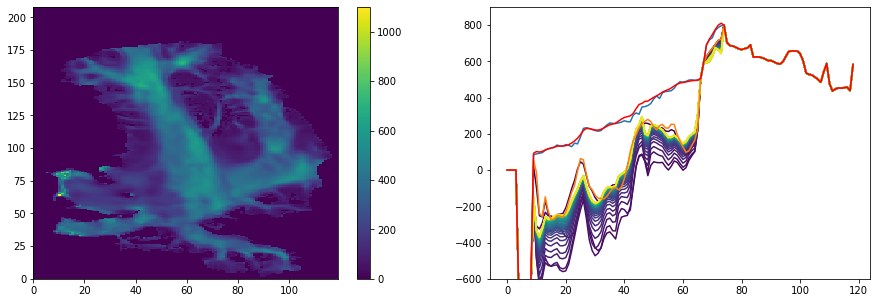

In [52]:
colormap = plt.cm.viridis
colors = [colormap(i) for i in np.linspace(0, 1,len(B_rec_all))]
fig, axes = plt.subplots(1,2, figsize=(15,5))
field = axes[0].pcolor(S_rec - B_rec)#, vmin=-50, vmax=50, cmap='RdBu')
fig.colorbar(field, ax=axes[0])
for i in range(0,len(B_rec_all),10):
    lines = axes[1].plot(range(nx), B_rec_all[i][40,:], color=colors[i])
lines2 = axes[1].plot(range(nx), NPI_DEM[40,:])
lines2 = axes[1].plot(range(nx), B_init[40,:])
lines2 = axes[1].plot(range(nx), S_rec[40,:], color='r')
axes[1].set_ylim([-600,900])

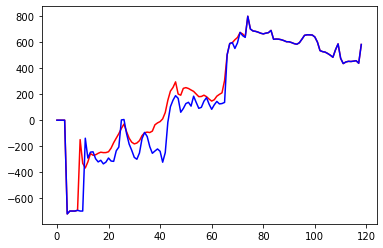

In [56]:
plt.plot(range(nx), B_recs[1][40,:], color='r')
plt.plot(range(nx), B_recs[0][40,:], color='b')


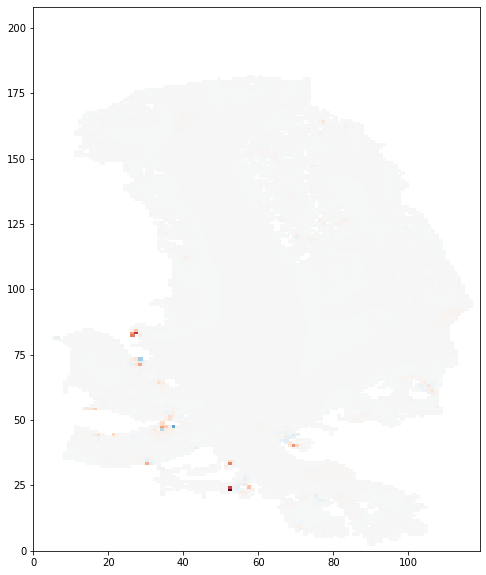

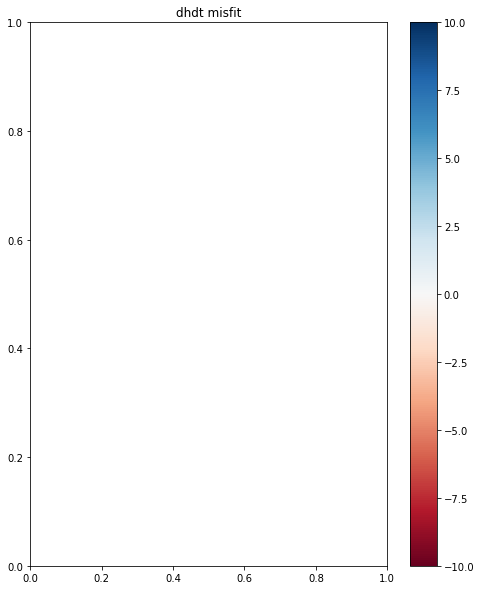

In [19]:
from IPython.display import display, clear_output #needed for animated plots

fig, axes = plt.subplots(figsize=(8,10))
for i in range(0,len(B_rec_all),10):
    field = axes.pcolor(misfit_all[i], cmap='RdBu', vmin=-10, vmax=10)
    #field = axes.pcolor(S_rec_all[i]-B_rec_all[i], vmax=800, vmin=0)
    clear_output(wait=True)
    display(fig)
    axes.cla()
axes.set_title('dhdt misfit')
fig.colorbar(field)

In [17]:
boundary = np.zeros_like(B_rec)
for i in range(np.shape(B_rec)[0]-1):
    for j in range(np.shape(B_rec)[1]-1):
        if mask_Kr[i,j] == 1 and (mask_Kr[i+1, j] == 0 or mask_Kr[i-1, j] == 0 or mask_Kr[i, j+1] == 0 or mask_Kr[i,j-1] == 0):
            boundary[i,j] = 1

In [18]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

src_file = '/home/thomas/pism-stable/examples1/Kronebreen/figures/Kronebreen_basemap.tif'
dst_file = 'Kronebreen_basemap_reproject.tif'
#gdf = gpd.read_file('./rgi_outlines/07_rgi60_Svalbard.shp')
dst_crs = NPI_DEM_o.crs

with rasterio.open(src_file) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    #with rasterio.open(dst_file, 'w', **kwargs) as dst:
    #    for i in range(1, src.count + 1):
    #        reproject(
    #            source=rasterio.band(src, i),
    #            destination=rasterio.band(dst, i),
    #            src_transform=src.transform,
    #            src_crs=src.crs,
    #            dst_transform=transform,
    #            dst_crs=dst_crs,
    #            resampling=Resampling.nearest)

In [19]:
basemap_o = rasterio.open(dst_file)
basemap = basemap_o.read(out_shape=(basemap_o.count, int(basemap_o.height*basemap_o.res[0]/250), int(basemap_o.height*basemap_o.res[1]/250)))

In [20]:
with rasterio.open('S0_DTM50.tif') as src:
    profile = src.profile.copy()

    aff = src.transform
    newaff = rasterio.Affine(aff.a  * 5, aff.b, aff.c+window.col_off*50,
                             aff.d, aff.e * 5, aff.f-window.row_off*50)
    profile.update({
            'dtype': 'float32',
            'height': B_rec.shape[0],
            'width': B_rec.shape[1],
            'transform': newaff}) 
    
with rasterio.open('/home/thomas/pism-stable/examples1/Kronebreen/figures/B_rec.tif', 'w', **profile) as dst:
    dst.write_band(1, np.flip(B_rec, axis=0))
    
bedmap_o = rasterio.open('./figures/B_rec.tif')
bedmap = bedmap_o.read()

with rasterio.open('/home/thomas/pism-stable/examples1/Kronebreen/figures/B_rec_mask_Kr.tif', 'w', **profile) as dst:
    B_rec_mask_Kr = np.zeros_like(B_rec)*np.nan
    B_rec_mask_Kr[mask_Kr==1] = B_rec[mask_Kr==1]
    dst.write_band(1, np.flip(B_rec_mask_Kr, axis=0))
    
bedmap_mask_o = rasterio.open('./figures/B_rec_mask_Kr.tif')
bedmap_mask = bedmap_mask_o.read()
    
with rasterio.open('/home/thomas/pism-stable/examples1/Kronebreen/figures/dhdt.tif', 'w', **profile) as dst:
    dhdt_mask = np.zeros_like(dhdt_full_new)*np.nan
    dhdt_mask[mask_Kr==1] = dhdt_full_new[mask_Kr==1]
    dst.write_band(1, np.flip(dhdt_mask, axis=0))
    
dhdt_o = rasterio.open('./figures/dhdt.tif')
dhdt = dhdt_o.read()

with rasterio.open('/home/thomas/pism-stable/examples1/Kronebreen/figures/mask_Kr.tif', 'w', **profile) as dst:
    dst.write_band(1, np.flip(mask_Kr, axis=0))
    
with rasterio.open('/home/thomas/pism-stable/examples1/Kronebreen/figures/boundary_Kr.tif', 'w', **profile) as dst:
    boundary_Kr = np.zeros_like(boundary) * np.nan
    boundary_Kr[boundary == 1] = 1
    dst.write_band(1, np.flip(boundary_Kr, axis=0))
    
boundary_o = rasterio.open('./figures/boundary_Kr.tif')

with rasterio.open('/home/thomas/pism-stable/examples1/Kronebreen/figures/smb.tif', 'w', **profile) as dst:
    smb_mask = np.zeros_like(smb_fit)*np.nan
    smb_mask[mask_Kr==1] = smb_fit[mask_Kr==1]
    dst.write_band(1, np.flip(smb_mask, axis=0))
    
smb_o = rasterio.open('./figures/smb.tif')

with rasterio.open('/home/thomas/pism-stable/examples1/Kronebreen/figures/S_rec_mask_Kr.tif', 'w', **profile) as dst:
    S_rec_mask_Kr = np.zeros_like(S_rec)*np.nan
    S_rec_mask_Kr[mask_Kr==1] = S_rec[mask_Kr==1]
    dst.write_band(1, np.flip(S_rec_mask_Kr, axis=0))
    
S_rec_o = rasterio.open('./figures/S_rec_mask_Kr.tif')

with rasterio.open('/home/thomas/pism-stable/examples1/Kronebreen/figures/thick_mask_Kr.tif', 'w', **profile) as dst:
    thick_mask_Kr = np.zeros_like(S_rec)*np.nan
    thick_mask_Kr[mask_Kr==1] = S_rec[mask_Kr==1] - B_rec[mask_Kr==1]
    dst.write_band(1, np.flip(thick_mask_Kr, axis=0))
    
thick_o = rasterio.open('./figures/thick_mask_Kr.tif')

with rasterio.open('/home/thomas/pism-stable/examples1/Kronebreen/figures/shading.tif', 'w', **profile) as dst:
    shading = thick_mask_Kr*0
    dst.write_band(1, np.flip(shading, axis=0))
    
shading_o = rasterio.open('./figures/shading.tif')

In [42]:
B_rec = get_nc_data('kronebreen_kongsbreen_iteration_out.nc', 'topg', 0)
S_rec = get_nc_data('kronebreen_kongsbreen_iteration_out.nc', 'usurf', 0)
vel = get_nc_data('kronebreen_kongsbreen_iteration_out.nc', 'velbar_mag', 0)
#B_rec = get_nc_data('kronebreen_kongsbreen_iteration_out.nc', 'topg', 0)

In [21]:
from matplotlib import colors
cmap_dhdt = plt.cm.RdBu
bounds_dhdt=np.linspace(-5,5, 1000)
norm_dhdt = colors.BoundaryNorm(bounds_dhdt, cmap_dhdt.N)

cmap_smb = plt.cm.RdBu
bounds_smb=np.linspace(-3,3, 1000)
norm_smb = colors.BoundaryNorm(bounds_smb, cmap_smb.N)

cmap_bed = plt.cm.terrain
bounds_bed=[-300, -200, -100, 0,100, 200,300, 400,500,600,700, 800,900, 1000, 1100,1200]
norm_bed = colors.BoundaryNorm(bounds_bed, cmap_bed.N)

cmap_thick = plt.cm.viridis
bounds_thick= np.linspace(0, 800)
norm_thick = colors.BoundaryNorm(bounds_thick, cmap_thick.N)

cmap_bederror = plt.cm.RdBu
bounds_bederror=np.linspace(-200,200, 1000)
norm_bederror = colors.BoundaryNorm(bounds_bederror, cmap_bederror.N)

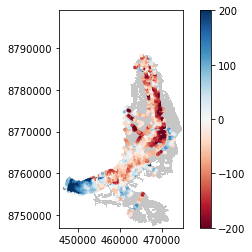

<Figure size 432x288 with 0 Axes>

In [22]:
fig, ax = plt.subplots()
field = ax.scatter(np.array(df['x_rad']), np.array(df['y_rad']), c=(thick_rec_at_rad - thick_ref_at_rad), cmap='RdBu', s=5, vmin=-200, vmax=200)
fig.colorbar(plt.cm.ScalarMappable(norm=norm_bederror, cmap='RdBu'), ax = ax, ticks=[-200,-100,0,100,200])
#rasterio.plot.show(boundary_o, ax = ax[1,2])
rasterio.plot.show(shading_o, cmap='Greys', vmin=-.5, vmax=1)
plt.savefig('./figures/Kronebreen_bed_misfit.png', dpi=799)

/home/thomas/.local/lib/python3.8/site-packages/rasterio/plot.py:139: UserWarning: The following kwargs were not used by contour: 'levles'
  C = ax.contour(arr, origin='upper', **kwargs)


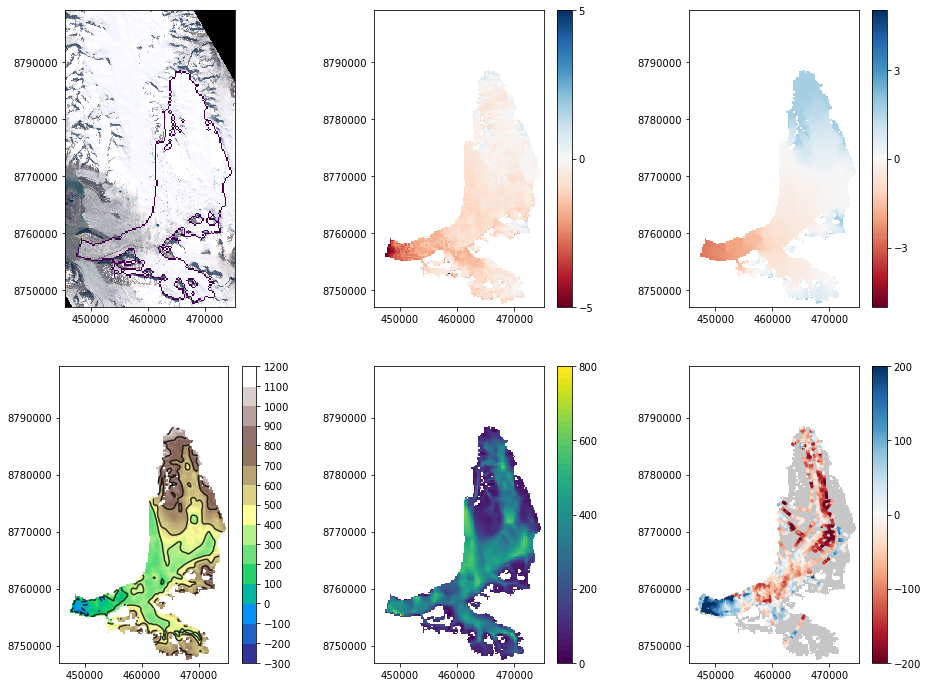

<Figure size 432x288 with 0 Axes>

In [24]:
fig, ax = plt.subplots(2,3, figsize=(16,12))
rasterio.plot.show(basemap_o, ax=ax[0,0], alpha=1)
rasterio.plot.show(boundary_o, ax = ax[0,0])

rasterio.plot.show(dhdt_o, ax=ax[0,1], cmap='RdBu', vmin = -5, vmax = 5)
fig.colorbar(plt.cm.ScalarMappable(norm=norm_dhdt, cmap='RdBu'), ax = ax[0,1], ticks=[-5,0,5])

rasterio.plot.show(smb_o, ax=ax[0,2], cmap='RdBu', vmin = -3, vmax = 3)
fig.colorbar(plt.cm.ScalarMappable(norm=norm_dhdt, cmap='RdBu'), ax = ax[0,2], ticks=[-3,0,3])


rasterio.plot.show(bedmap_mask_o, ax=ax[1,0], cmap=cmap_bed)
rasterio.plot.show(bedmap_mask_o, ax=ax[1,0], contour=True, colors='black', contour_label_kws={}, levles=bounds_bed)
fig.colorbar(plt.cm.ScalarMappable(norm=norm_bed, cmap='terrain'), ax = ax[1,0], ticks=bounds_bed)

rasterio.plot.show(thick_o, ax=ax[1,1], cmap=cmap_thick)
fig.colorbar(plt.cm.ScalarMappable(norm=norm_thick, cmap='viridis'), ax = ax[1,1], ticks=[0,200, 400, 600, 800])



field = ax[1,2].scatter(np.array(df['x_rad']), np.array(df['y_rad']), c=(thick_rec_at_rad - thick_ref_at_rad), cmap='RdBu', s=5, vmin=-200, vmax=200)
fig.colorbar(plt.cm.ScalarMappable(norm=norm_bederror, cmap='RdBu'), ax = ax[1,2], ticks=[-200,-100,0,100,200])
#rasterio.plot.show(boundary_o, ax = ax[1,2])
rasterio.plot.show(shading_o, cmap='Greys', vmin=-.5, vmax=1)

#outline_Kr.plot(edgecolor='black', facecolor='', ax = ax[1,1])
#rasterio.plot.show(src_o, ax = ax[1])

for a in ax.flatten():
    a.set_xlim([445000,477000])
    a.set_ylim([8745500,8790000])
    a.axis('off')
    
plt.savefig('./figures/Kronebreen_panel.png', dpi=800, transparent=True)


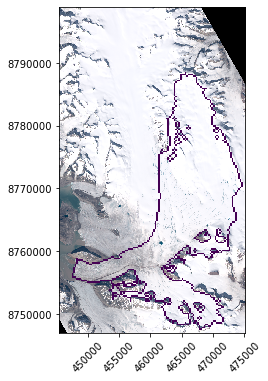

In [41]:
fig, ax = plt.subplots(figsize=(8,6))
rasterio.plot.show(basemap_o, ax=ax, alpha=1)
rasterio.plot.show(boundary_o, ax = ax)
ax.tick_params(axis='both', which='major', labelsize=10)
plt.xticks(rotation=45)
plt.savefig('./figures/Kronebreen_satellite.png', dpi=800)

In [46]:
Z_at_rad = get_nearest(x[mask==1],y[mask==1],NPI_DEM[mask==1], x_rad, y_rad)

df = pd.DataFrame({"Z":Z_at_rad,"rad":rad[:,0], "x_rad":x_rad[:,0], "y_rad": y_rad[:,0]})
df = df.groupby('Z').mean()
thick_ref_at_rad = df.index - df['rad']
thick_rec = S_rec - B_rec
thick_rec_at_rad = get_nearest(x[mask==1], y[mask==1], thick_rec[mask==1], np.array(df['x_rad']), np.array(df['y_rad']))

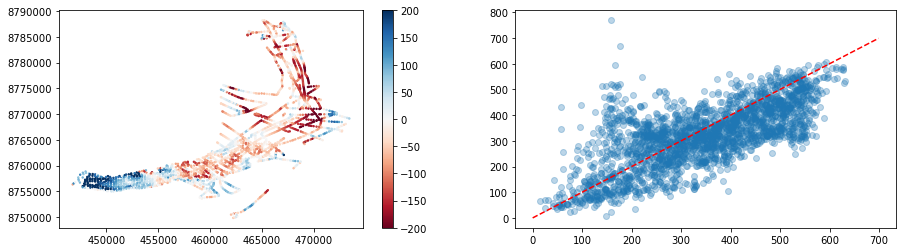

In [58]:
fig, ax = plt.subplots(1,2, figsize=(15,4))
field = ax[0].scatter(np.array(df['x_rad']), np.array(df['y_rad']), c=(thick_rec_at_rad - thick_ref_at_rad), cmap='RdBu', s=2, vmin=-200, vmax=200)
fig.colorbar(field, ax = ax[0])

scatter = ax[1].scatter(thick_ref_at_rad, thick_rec_at_rad, marker='o', alpha=.3)
line = ax[1].plot(range(700), range(700), '--', c='r')

In [34]:
import scipy.stats as st
#max_cor_ind = int(np.where(cors==np.max(cors))[0])
dev = (thick_rec_at_rad - thick_ref_at_rad)/np.mean(thick_ref_at_rad)
mean_dev = np.nanmean((dev))
mean_abs_dev = np.nanmean(abs(thick_rec_at_rad - thick_ref_at_rad))
med_dev = np.nanmedian((dev))
IQR_dev = np.nanpercentile(dev, 75) - np.nanpercentile(dev, 25)
conf_dev = mean_dev-st.t.interval(0.95, len(dev)-1, loc=np.nanmean(dev), scale=st.sem(dev[~np.isnan(dev)]))
RMSE = math.sqrt(mean_squared_error(thick_ref_at_rad, thick_rec_at_rad))
print('RMSE: {} m'.format(RMSE))
print('mean deviation: {} %'.format(mean_dev))
print('mean absolute deviation: {} m'.format(mean_abs_dev))
print('median deviation: {} %'.format(med_dev))
print('Interquartile range of deviation: {}'.format(IQR_dev))
print('95% confidence intervall: {}'.format(conf_dev))

RMSE: 103.19567249588422 m
mean deviation: -0.06345156065646039 %
mean absolute deviation: 79.84586345135124 m
median deviation: -0.09201567870195534 %
Interquartile range of deviation: 0.3340307395249637
95% confidence intervall: [ 0.01214144 -0.01214144]


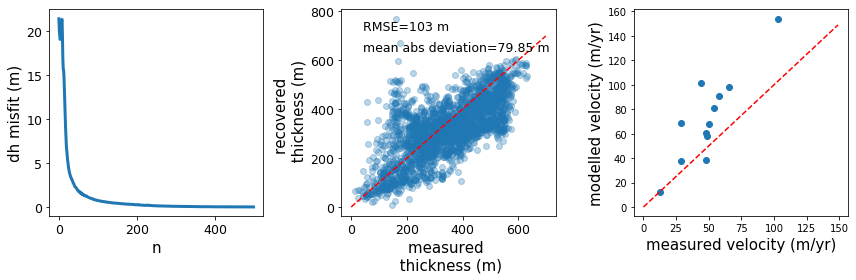

In [29]:
fs = 15

fig, ax = plt.subplots(1,3, figsize=(12,4))
line = ax[0].plot(np.nanmean(abs(np.array(misfit_all)), axis=(1,2)), linewidth = 3)
#line = ax.plot(np.convolve(np.nanmean(abs(np.array(misfit_all)), axis=(1,2)), np.ones(5)/5))
#ax[0].set_ylim([0,3])
#line2 = ax[1].plot(dh_misfit_vs_iter)
#line1 = ax[1].plot(np.convolve(dh_misfit_vs_iter, np.ones(50)/50, mode='same'))

ax[0].set_xlabel('n', fontsize=fs)
ax[0].set_ylabel('dh misfit (m)', fontsize=fs)
ax[0].tick_params(axis='both', which='major', labelsize=fs/1.2)

scatter = ax[1].scatter(thick_ref_at_rad, thick_rec_at_rad, marker='o', alpha=.3)
line = ax[1].plot(range(700), range(700), '--', c='r')

ax[1].set_xlabel('measured \n thickness (m)', fontsize=fs)
ax[1].set_ylabel('recovered \n thickness (m)', fontsize=fs)
ax[1].tick_params(axis='both', which='major', labelsize=fs/1.2)
ax[1].text(.1, .9, 'RMSE={} m'.format(int(RMSE)), transform = ax[1].transAxes, fontsize=fs/1.2)
ax[1].text(.1, .8, 'mean abs deviation={} m'.format(round(mean_abs_dev, 2)), transform = ax[1].transAxes, fontsize=fs/1.2)

#axins = inset_axes(ax[0], width="50%", height="50%", loc=1)
scatter = ax[2].scatter(vel_0914, get_nearest(x,y,vels[2], vel_x, vel_y))
line = ax[2].plot(range(150), range(150), '--', c='r')
ax[2].set_xlabel('measured velocity (m/yr)', fontsize=fs)
ax[2].set_ylabel('modelled velocity (m/yr)', fontsize= fs)

plt.tight_layout()

plt.savefig('./figures/misfit_correlation.svg')

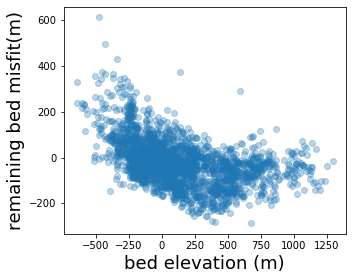

In [69]:
data_at_rad = get_nearest(x,y,get_nc_data('kronebreen_iteration_out.nc', 'topg', 0), np.array(df['x_rad']), np.array(df['y_rad']))
#data_at_rad = get_nearest(x,y, B_rec, np.array(df['x_rad']), np.array(df['y_rad']))
fig, ax = plt.subplots(figsize=(5,4))
points = ax.scatter(data_at_rad, (thick_rec_at_rad - thick_ref_at_rad), alpha=.3)
ax.set_xlabel('bed elevation (m)', fontsize=18)
ax.set_ylabel('remaining bed misfit(m)', fontsize=18)
plt.tight_layout()
plt.savefig('./figures/KK_bed_misfit_per_elevation.png', dpi = 400)

In [39]:
import glob

mods = glob.glob('KK*')

S_recs = []
B_recs = []
vels = []
ms = [mods[6], mods[7]]


for m in ms:
    bk_restore = shelve.open(m)
    try:
        S_recs.append(bk_restore['S_rec'])
        B_recs.append(bk_restore['B_rec'])
        vels.append(np.sqrt(bk_restore['u']**2+bk_restore['v']**2))
    except KeyError:
        print('variables not found in {}'.format(m))
    bk_restore.close()

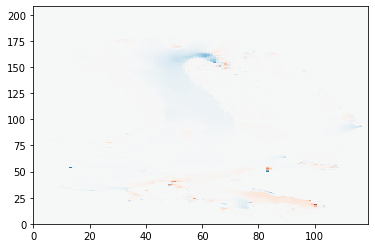

In [57]:
plt.pcolor(B_rec - B_recs[0], vmax=100, vmin = -100, cmap='RdBu')

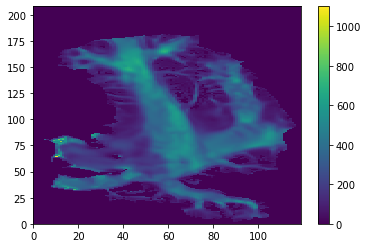

In [48]:
fig, ax = plt.subplots()
field = ax.pcolor(thick_rec)
fig.colorbar(field, ax = ax)

In [46]:
thick_rec = S_recs[1] - B_recs[1]
thick_rec_at_rad = get_nearest(x[mask==1], y[mask==1], thick_rec[mask==1], np.array(df['x_rad']), np.array(df['y_rad']))
    

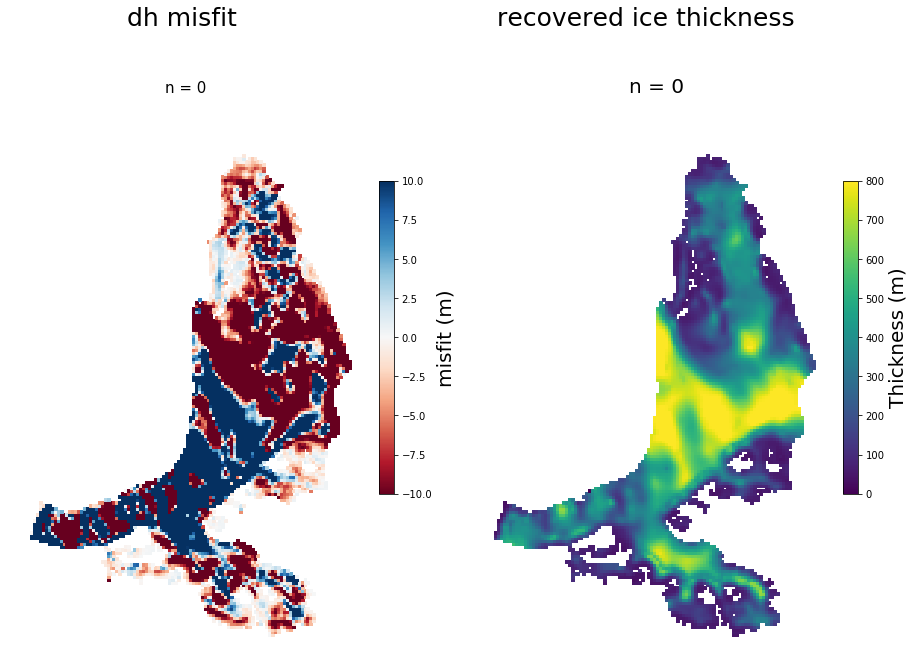

In [33]:
import itertools
import matplotlib.animation as animation

nan_mask = np.zeros_like(B_rec)*np.nan
nan_mask[mask_Kr==1] = 1

zmin = -10
zmax = 10
kw_dh = dict(cmap=plt.cm.RdBu, vmin=zmin, vmax=zmax)
kw_B = dict(cmap=plt.cm.viridis, vmin = 0, vmax=800)

fig,ax = plt.subplots(1,2, figsize=(13,10), sharey=True)
field = ax[0].pcolor(dh_all[0]*nan_mask, **kw_dh)
cbar = plt.colorbar(field, ax = ax[0], shrink = .5)
cbar.set_label('misfit (m)', fontsize= 20)
ax[0].set_aspect('equal', 'box')

field = ax[1].pcolor(S_rec_all[0]*nan_mask-B_rec_all[0]*nan_mask, **kw_B)
cbar = plt.colorbar(field, ax = ax[1], shrink = .5)
cbar.set_label('Thickness (m)', fontsize= 20)
ax[1].set_aspect('equal', 'box')

ax[0].set_ylabel('y (km)', fontsize=20)
ax[0].set_xlabel('x (km)', fontsize=20)
ax[1].set_xlabel('x (km)', fontsize=20)

ax[0].axis('off')
ax[1].axis('off')

def animate_dh(index):
    ax[0].clear()
    ax[0].pcolor(dh_all[index]*nan_mask, **kw_dh)
    ax[0].text(.45,.9,'n = {}'.format(index), transform = ax[0].transAxes, fontsize=15)
    ax[0].set_title('dh misfit', fontsize=25)
    ax[0].set_aspect('equal', 'box')
    ax[0].set_xlabel('x (km)', fontsize=20)
    ax[0].set_ylabel('y (km)', fontsize=20)
    ax[0].axis('off')

    ax[1].clear()
    ax[1].pcolor(S_rec_all[index]*nan_mask-B_rec_all[index]*nan_mask, **kw_B)
    ax[1].text(.45,.9,'n = {}'.format(index), transform = ax[1].transAxes, fontsize=20, color='black')
    ax[1].set_title('recovered ice thickness', fontsize=25)
    ax[1].set_aspect('equal', 'box')
    ax[1].set_xlabel('x (km)', fontsize=20)
    ax[1].axis('off')

ani = animation.FuncAnimation(fig,animate_dh,range(0,len(dh_all), 2),interval=100,blit=False)

plt.tight_layout(rect=(0,0,1,.9), w_pad = .2)
plt.show()
ani.save('Kronebreen_misfit_thk_animation.mp4', dpi = 300)

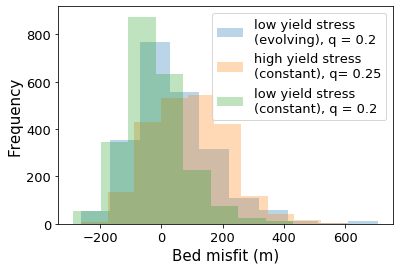

In [89]:
ls = 15
lables = ['low yield stress\n(evolving), q = 0.2', 'high yield stress\n(constant), q= 0.25', 'low yield stress\n(constant), q = 0.2']
fig, ax = plt.subplots()
for i in range(len(S_recs)):
    thick_rec = S_recs[i] - B_recs[i]
    thick_rec_at_rad = get_nearest(x[mask==1], y[mask==1], thick_rec[mask==1], np.array(df['x_rad']), np.array(df['y_rad']))
    #field = plt.scatter(np.array(df['x_rad']), np.array(df['y_rad']), c=(thick_rec_at_rad - thick_ref_at_rad), cmap='RdBu', s=2, vmin=-300, vmax=300)
    hist = ax.hist(thick_rec_at_rad - thick_ref_at_rad, alpha = .3, label=lables[i])
    
ax.legend(loc=1, fontsize=13)
ax.set_xlabel('Bed misfit (m)', fontsize = ls)
ax.set_ylabel('Frequency', fontsize = ls)
ax.tick_params(axis='both', which='major', labelsize=13)

plt.savefig('./figures/misfit_hist.png', dpi = 800)